#  Churn prediction model 

Este notebook implementa um pipeline robusto de Machine Learning para prever Churn de clientes.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import shap


pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
SEED = 42
FOLDS = 5

## 1. Carregamento e Preparação dos Dados

In [12]:
# Carregar dados processados
df_train = pd.read_csv('history_fe.csv')
df_inference = pd.read_csv('inference_fe.csv')

print(f"Treino Shape: {df_train.shape}")
print(f"Inferencia Shape: {df_inference.shape}")

# Separar Features e Target
X = df_train.drop(['customerID', 'Churn', 'CustomerFeedback'], axis=1, errors='ignore')

# Converter target para numérico 
y = df_train['Churn'].apply(lambda x: 1 if x == 'Yes' or x == 1 else 0)

print(f"\nFeatures ({X.shape[1]}): {list(X.columns[:5])}...")
print(f"Target Balance:\n{y.value_counts(normalize=True)}")

Treino Shape: (5634, 45)
Inferencia Shape: (1409, 43)

Features (42): ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService']...
Target Balance:
Churn
0    0.733049
1    0.266951
Name: proportion, dtype: float64


## 2. Construção do Pipeline de Validação


In [ ]:
def get_pipeline(model, use_smote=True):

    steps = [
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler())   
    ]
    
    if use_smote:
        steps.append(('smote', SMOTE(random_state=SEED)))
        
    steps.append(('model', model))
    
    return ImbPipeline(steps)

models = {
    'LogisticRegression': LogisticRegression(random_state=SEED, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=SEED, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(random_state=SEED, verbosity=-1),
    'CatBoost': CatBoostClassifier(random_state=SEED, verbose=0, allow_writing_files=False)
}

## 3. Treinamento e Seleção de Modelos (Baseline)

In [15]:
results = []

print("Iniciando Validação Cruzada\n")

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for name, model in models.items():
    print(f"Treinando {name}...")
    pipe = get_pipeline(model, use_smote=True)
    
    cv_scores = cross_val_score(pipe, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
    
    print(f"   ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})\n")
    results.append({
        'Model': name,
        'ROC_AUC_Mean': cv_scores.mean(),
        'ROC_AUC_Std': cv_scores.std()
    })

df_results = pd.DataFrame(results).sort_values(by='ROC_AUC_Mean', ascending=False)
print("\n Melhores de Modelos:")
print(df_results)

Iniciando Validação Cruzada

Treinando LogisticRegression...
   ROC-AUC: 0.9314 (+/- 0.0047)

Treinando RandomForest...
   ROC-AUC: 0.9096 (+/- 0.0056)

Treinando XGBoost...
   ROC-AUC: 0.9309 (+/- 0.0042)

Treinando LightGBM...
   ROC-AUC: 0.9331 (+/- 0.0039)

Treinando CatBoost...
   ROC-AUC: 0.9361 (+/- 0.0024)


 Melhores de Modelos:
                Model  ROC_AUC_Mean  ROC_AUC_Std
4            CatBoost      0.936110     0.002391
3            LightGBM      0.933130     0.003895
0  LogisticRegression      0.931379     0.004722
2             XGBoost      0.930855     0.004188
1        RandomForest      0.909564     0.005632


## 4. Otimização de Hiperparâmetros (Champion Model)

In [17]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

print("\n Iniciando Grid Search para XGBoost")
xgb_pipe = get_pipeline(XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='logloss'), use_smote=True)

grid_search = RandomizedSearchCV(
    xgb_pipe, 
    param_distributions=param_grid, 
    n_iter=20,
    scoring='roc_auc', 
    cv=3, 
    n_jobs=-1, 
    random_state=SEED, 
    verbose=1
)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print(f"\n Melhores Parâmetros: {grid_search.best_params_}")
print(f" Melhor ROC-AUC: {grid_search.best_score_:.4f}")


 Iniciando Grid Search para XGBoost
Fitting 3 folds for each of 20 candidates, totalling 60 fits

 Melhores Parâmetros: {'model__subsample': 1.0, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}
 Melhor ROC-AUC: 0.9338


##  5. Avaliação Final e Curvas



 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       826
           1       0.74      0.75      0.75       301

    accuracy                           0.86      1127
   macro avg       0.82      0.83      0.83      1127
weighted avg       0.86      0.86      0.86      1127

ROC-AUC Score: 0.9328


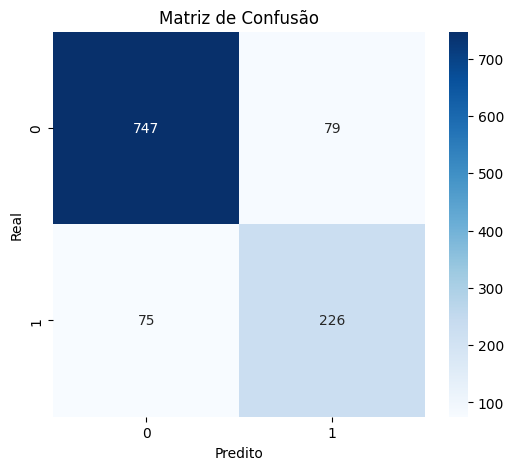

In [18]:
# Split de validação final para visualização
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Treinar melhor modelo no conjunto de treino
best_model.fit(X_train, y_train)

# Previsões
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:, 1]

print("\n Relatório de Classificação:")
print(classification_report(y_val, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob):.4f}")

# Matriz de Confusão Visual
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

## 6. Interpretabilidade com SHAP


 SHAP Summary Plot (Impacto das Features):


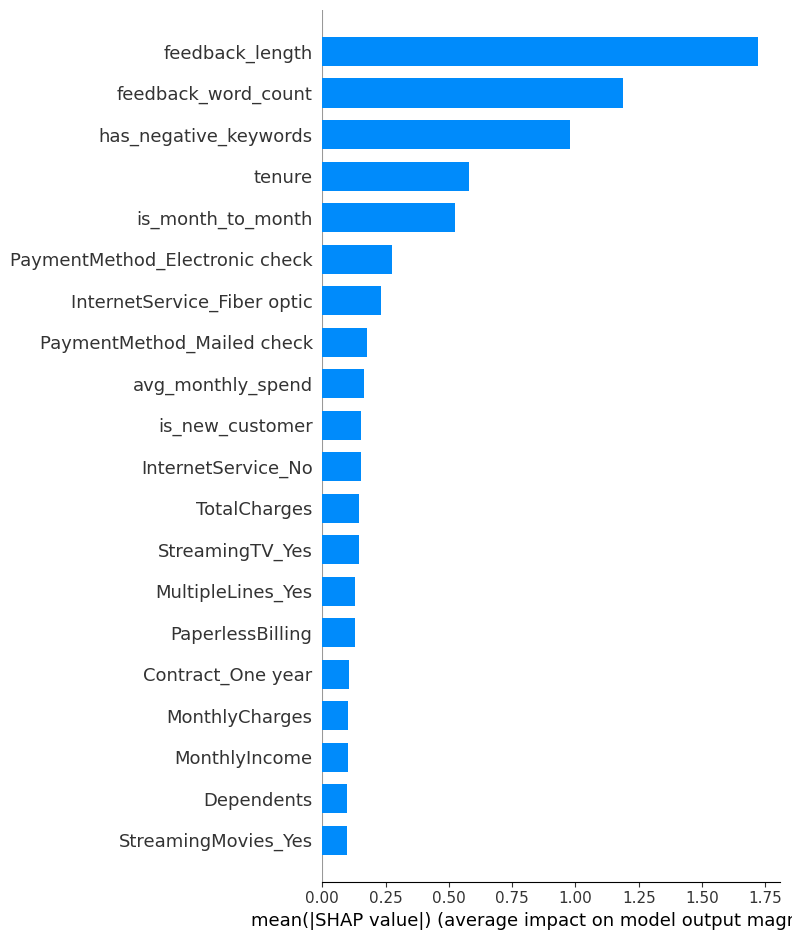

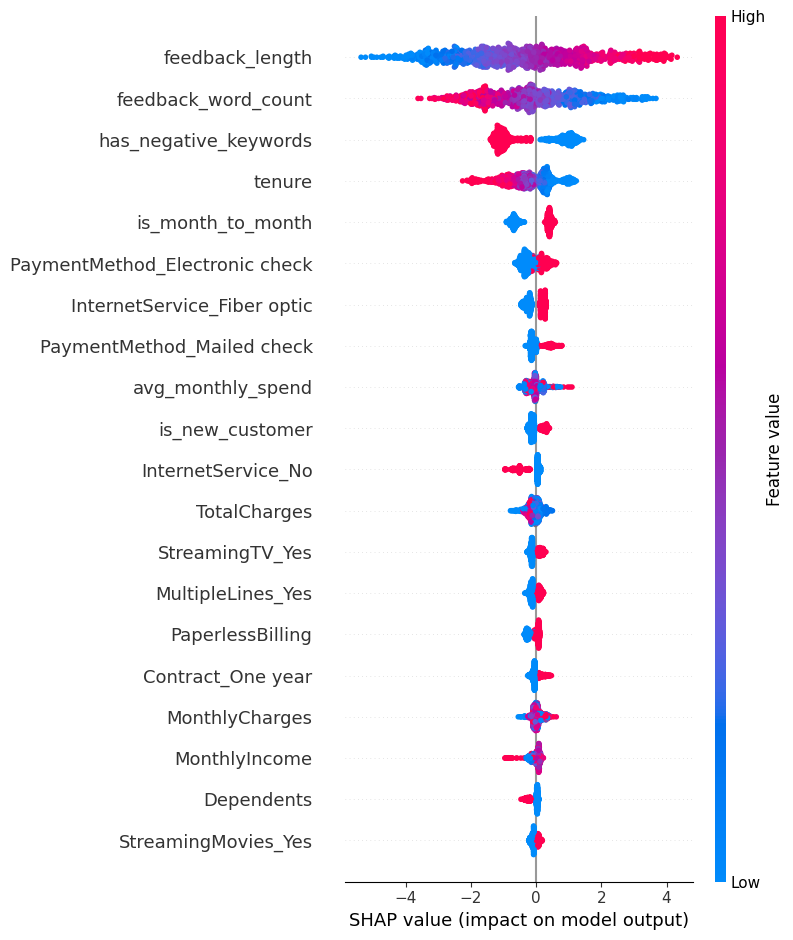

In [19]:
# SHAP para XGBoost/Tree models
final_estimator = best_model.named_steps['model']

transformers = [s for s in best_model.steps if s[0] not in ['smote', 'model']]
preprocessor = ImbPipeline(transformers)

# Ajustar preprocessor nos dados de treino (apenas transformações)
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_val_transformed = preprocessor.transform(X_val)

# Calcular SHAP values
explainer = shap.TreeExplainer(final_estimator)
shap_values = explainer.shap_values(X_val_transformed)

print("\n SHAP Summary Plot (Impacto das Features):")
shap.summary_plot(shap_values, X_val, plot_type="bar")
shap.summary_plot(shap_values, X_val)

## 7. Inferência do Modelo Final, Probabilidades e Segmentação de Risco


In [20]:
# Garantir que features de NLP do treino existam na inferência
if 'feedback_word_count' not in df_inference.columns and 'CustomerFeedback' in df_inference.columns:
    print(" Recriando feature 'feedback_word_count'...")
    df_inference['feedback_word_count'] = df_inference['CustomerFeedback'].astype(str).str.split().str.len().fillna(0)

# Selecionar features (dropando as que não vão para o modelo)
X_inf = df_inference.drop(['customerID', 'Churn', 'CustomerFeedback'], axis=1, errors='ignore')

# Garantir consistência exata das colunas com o treino (Ordem e Presença)
missing_cols = set(X.columns) - set(X_inf.columns)
for c in missing_cols:
    X_inf[c] = 0  # Preencher features faltantes com 0 se necessário

X_inf = X_inf[X.columns] # Reordenar exatamente igual ao treino

ids = df_inference['customerID']

# Gerar Probabilidades (0 a 1)
probs = best_model.predict_proba(X_inf)[:, 1]

# Criar DataFrame de resultados
results_df = pd.DataFrame({
    'customerID': ids,
    'Churn_Probability': probs.round(4)
})

# Segmentação de Risco por Percentis
# Low Risk (0-50%), Medium Risk (50-75%), High Risk (75-100%)
results_df['Risk_Level'] = pd.qcut(results_df['Churn_Probability'], 
                                   q=[0, 0.5, 0.75, 1.0], 
                                   labels=['Low Risk', 'Medium Risk', 'High Risk'])

print("\n Distribuição dos Níveis de Risco (Percentis):")
print(results_df['Risk_Level'].value_counts())

print("\n Top 10 Clientes com Maior Risco de Churn:")
print(results_df.sort_values(by='Churn_Probability', ascending=False).head(10))

# Salvar
results_df.to_csv('predictions_with_risk.csv', index=False)
print("\n Arquivo salvo: predictions_with_risk.csv")

 Recriando feature 'feedback_word_count'...

 Distribuição dos Níveis de Risco (Percentis):
Risk_Level
Low Risk       705
Medium Risk    352
High Risk      352
Name: count, dtype: int64

 Top 10 Clientes com Maior Risco de Churn:
      customerID  Churn_Probability Risk_Level
1121  6513-EECDB             0.9973  High Risk
1112  5376-DEQCP             0.9946  High Risk
1393  4102-OQUPX             0.9941  High Risk
1152  4910-GMJOT             0.9921  High Risk
971   9787-XVQIU             0.9913  High Risk
1245  9248-OJYKK             0.9910  High Risk
1377  0107-YHINA             0.9901  High Risk
840   6100-QQHEB             0.9899  High Risk
651   5276-KQWHG             0.9894  High Risk
692   4550-EVXNY             0.9885  High Risk

 Arquivo salvo: predictions_with_risk.csv


## 8. Calculando o risco de cada feature para cada inferencia

In [ ]:
# 1. Separar o modelo XGBoost do restante do pipeline
pipeline_steps = best_model.named_steps
preprocessor = ImbPipeline([
    ('imputer', pipeline_steps['imputer']),
    ('scaler', pipeline_steps['scaler'])
])
xgboost_model = pipeline_steps['model']

# 2. Transformar os dados de inferência (X_inf) para a escala que o modelo entende
X_inf_transformed = preprocessor.transform(X_inf)

# 3. Criar o Explainer do SHAP
explainer = shap.TreeExplainer(xgboost_model)

# 4. Calcular os valores SHAP para toda a base de inferência
shap_values_inf = explainer.shap_values(X_inf_transformed)

# Criar um DataFrame com os valores SHAP para facilitar a manipulação
df_shap = pd.DataFrame(shap_values_inf, columns=X_inf.columns)

In [36]:
def get_top_risk_drivers(customer_index, shap_df, feature_values_df, actions_map, top_n=3):
    # Pegar os valores SHAP do cliente
    customer_shaps = shap_df.iloc[customer_index]
    
    # Filtrar apenas o que aumenta o risco (SHAP > 0) e ordenar do maior para o menor
    risk_drivers = customer_shaps[customer_shaps > 0].sort_values(ascending=False).head(top_n)
    
    drivers_list = []
        
    for feature, shap_impact in risk_drivers.items():
        # Valor original da feature para contexto
        original_value = feature_values_df.iloc[customer_index][feature]
        
        # Tenta pegar uma ação mapeada, se não tiver, usa uma genérica
        suggestion = actions_map.get(feature, f"Investigar {feature}")
        
        drivers_list.append({
            'Feature': feature,
            'Valor_Original': original_value,
            'Impacto_no_Risco': round(shap_impact, 4),
            'Sugestão_Ação': suggestion
        })
        
    return drivers_list

## Sugestões de soluções para cada feature  


In [43]:
actions_map = {
    'MonthlyCharges': 'Fatura Alta: Oferecer plano custo-benefício, revisar serviços adicionais ou aplicar desconto temporário.',
    'TotalCharges': 'LTV Alto: Cliente valioso. Oferecer tratamento VIP, upgrade de equipamento gratuito ou bônus de fidelidade.',
    'MonthlyIncome': 'Sensibilidade a Preço: Se renda estimada for baixa, focar em planos básicos/econômicos. Se alta, focar em qualidade/premium.',
    'PaperlessBilling': 'Fatura Digital: Verificar se cliente recebe os e-mails. Se houver atrito, oferecer suporte para pagamento.',
    'PaymentMethod_Electronic check': 'Método de Risco: Este método tem alto churn. Incentivar migração para Débito Automático/Crédito com desconto.',
    'PaymentMethod_Mailed check': 'Atrasos de Pagamento: Risco de esquecimento/correio. Sugerir migração para digital.',
    'PaymentMethod_Credit card (automatic)': 'Cartão: Verificar validade do cartão ou falhas recorrentes de cobrança.',
    'tenure': 'Ciclo de Vida: Se novo (<6 meses), fazer Onboarding/Boas-vindas. Se antigo (>24 meses), reconhecer fidelidade e renovar benefícios.',
    'SeniorCitizen': 'Acessibilidade: Verificar se o atendimento/fatura estão claros. Oferecer suporte dedicado se necessário.',
    'Partner': 'Individual: Cliente sem parceiro pode ser mais volátil. Verificar interesse em planos individuais flexíveis.',
    'Dependents': 'Sem Dependentes: Menor barreira de saída. Focar em benefícios pessoais (streaming, dados) em vez de familiares.',
    'gender_Male': 'Demográfico: Ação padrão de relacionamento.',
    'InternetService_Fiber optic': 'Fibra Óptica: Possível insatisfação técnica ou preço elevado. Agendar visita técnica preventiva ou revisar fatura.',
    'InternetService_No': 'Digitalização: Cliente desconectado. Oferecer plano de entrada de internet com degustação grátis.',
    'OnlineSecurity_Yes': 'Serviço Ativo: Verificar se está configurado/funcionando. O cliente vê valor?',
    'OnlineBackup_Yes': 'Uso do Backup: Garantir que o cliente ativou o armazenamento na nuvem.',
    'DeviceProtection_Yes': 'Seguro: Lembrar o cliente da cobertura em caso de sinistro.',
    'TechSupport_Yes': 'Chamados: Cliente que usa muito suporte pode estar frustrado. Analisar histórico técnico.',
    'StreamingTV_Yes': 'TV: Verificar qualidade do sinal ou interesse em novos canais.',
    'StreamingMovies_Yes': 'Filmes: Oferecer cupom de VOD ou degustação de canal premium.',
    'Contract_One year': 'Fim de Contrato: Risco de não renovação. Propor renovação antecipada vantajosa.',
    'Contract_Two year': 'Fim de Contrato Longo: Cliente blindado prestes a vencer. Ação de retenção prioritária.',
    'has_negative_keywords': 'Alerta de Sentimento: Cliente usou palavras negativas (ex: "ruim", "lento"), leia o comentário e busque melhorar o que foi criticado.',
    'feedback_length': 'Feedback Longo: Cliente detalhou um problema. Ler o comentário antes de contatar.',
    'feedback_word_count': 'Esforço do Cliente: Reclamação extensa. Priorizar atendimento focado no que foi criticado.',
    'CustomerFeedback': 'Análise Qualitativa: Verificar texto original para entender melhor o problema.'
}

In [38]:
def sugestão_adaptavel(feature, value, shap_value):
    
    # 1. Lógica para Serviços Adicionais (Security, Backup, Support, etc.)
    # Se a coluna termina em '_Yes'
    if feature.endswith('_Yes'):
        service_name = feature.replace('_Yes', '')
        if value == 0:
            return f"Venda Cruzada: Cliente em risco por não ter {service_name}. Oferecer trial gratuito/desconto."
        else:
            return f"Retenção Técnica: Cliente tem {service_name} mas pode estar insatisfeito ou achando caro. Verificar uso."

    # 2. Lógica para Internet Fibra
    if feature == 'InternetService_Fiber optic':
        if value == 1:
            return "Fibra Óptica: Verificar estabilidade do sinal na região e oferecer visita técnica se houver histórico de queda."

    # 3. Lógica para Pagamento
    if feature == 'PaymentMethod_Electronic check':
        if value == 1:
            return "Pagamento: Incentivar cadastro em Débito Automático para evitar esquecimento e taxas."

    # 4. Lógica para Contrato (Ausência de contrato longo = Risco)
    if 'Contract_' in feature and value == 0:
        return "Fidelização: Cliente provavelmente em contrato mensal (Month-to-month). Oferecer plano anual com desconto."

    # 5. Lógica para NLP (Feedback Negativo)
    if feature == 'has_negative_keywords':
        if value == 1:
            return "URGENTE: Detrator. Cliente usou palavras-chave negativas. Ligar para entender a dor."

    # 6. Lógica Numérica (Tenure e Preço)
    if feature == 'tenure':
        if value < 12:
            return "Early Churn: Cliente recente (<1 ano). Garantir que ele sabe usar os produtos contratados."
    
    if feature == 'MonthlyCharges':
        # Você pode ajustar esse limite de 80 baseado na média dos seus dados
        if value > 80:
            return "Preço: Fatura alta. Verificar possibilidade de down-sell (plano menor) para evitar cancelamento."

    # Retorno padrão do dicionário se nenhuma regra específica for ativada
    return actions_map.get(feature, "Analisar perfil do cliente e histórico de contato.")

## Testando a função 

In [40]:
# Vamos pegar um cliente que o modelo disse que é High Risk
high_risk_customer_idx = results_df[results_df['Risk_Level'] == 'High Risk'].index[0]
customer_id = df_inference.iloc[high_risk_customer_idx]['customerID']

print(f"Analisando Cliente: {customer_id}")
print(f"Probabilidade de Churn: {results_df.iloc[high_risk_customer_idx]['Churn_Probability']:.2%}")
print("-" * 30)

drivers = get_top_risk_drivers(high_risk_customer_idx, df_shap, X_inf, actions_map)

for driver in drivers:
    feature_name = driver['Feature']
    val_original = driver['Valor_Original']
    impact = driver['Impacto_no_Risco']
    
    sugestao = sugestão_adaptavel(feature_name, val_original, impact)
    
    print(f"Motivo: {feature_name} (Valor: {val_original})")
    print(f"Impacto (SHAP): +{impact}")
    print(f"AÇÃO SUGERIDA: {sugestao}")
    print("-" * 30)

Analisando Cliente: 0320-JDNQG
Probabilidade de Churn: 66.22%
------------------------------
Motivo: has_negative_keywords (Valor: 0)
Impacto (SHAP): +0.9173
AÇÃO SUGERIDA: Alerta de Sentimento: Cliente usou palavras negativas (ex: "ruim", "lento"). Ligar com empatia imediatamente.
------------------------------
Motivo: feedback_length (Valor: 493)
Impacto (SHAP): +0.6573
AÇÃO SUGERIDA: Feedback Longo: Cliente detalhou um problema. Ler o comentário antes de contatar.
------------------------------
Motivo: is_month_to_month (Valor: 1)
Impacto (SHAP): +0.4243
AÇÃO SUGERIDA: Analisar perfil do cliente e histórico de contato.
------------------------------


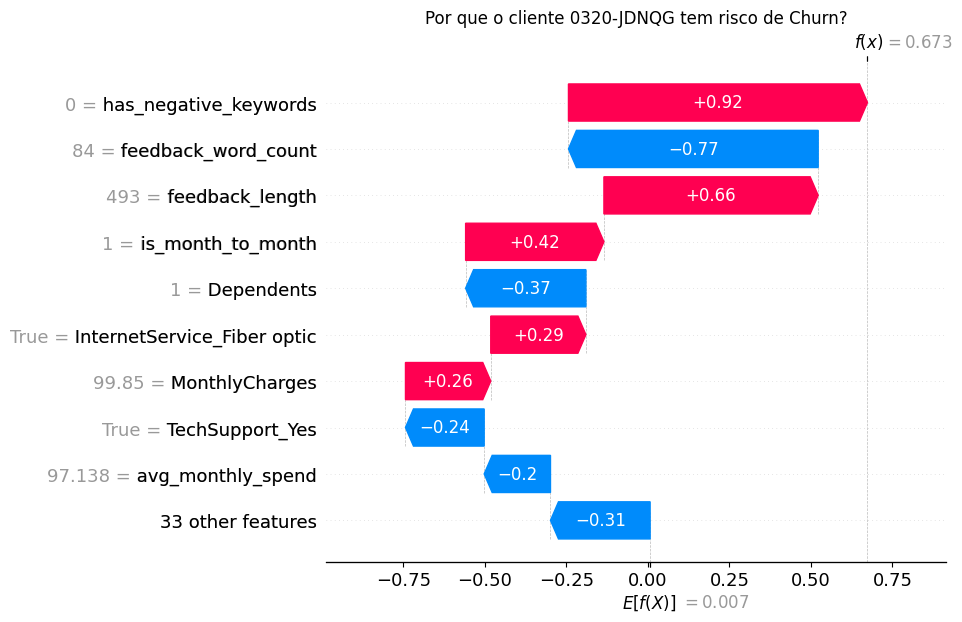

In [42]:
# Visualizar o "Waterfall plot" para o mesmo cliente acima
# Nota: precisamos passar o objeto Explanation para o waterfall novo do shap
shap_explanation = shap.Explanation(
    values=shap_values_inf[high_risk_customer_idx], 
    base_values=explainer.expected_value, 
    data=X_inf.iloc[high_risk_customer_idx], 
    feature_names=X_inf.columns
)

plt.title(f"Por que o cliente {customer_id} tem risco de Churn?")
shap.plots.waterfall(shap_explanation)